In [147]:
import pandas as pd
import numpy as np

decisions = pd.DataFrame()

for year in range(2017,2021):
    tmp = pd.read_csv(f"data/4th_downs/{year}.csv", encoding="latin-1", index_col=False)
    decisions = decisions.append(tmp)
    
decisions = decisions.loc[:, ~decisions.columns.str.contains('^Unnamed')]
decisions.play_id = decisions.play_id.astype(int)
decisions.drop_duplicates(subset=['play_id'], inplace=True)
decisions = decisions[(decisions['choice'].notna())]
decisions.head()

,game_id,play_id,season,week,desc,qtr,TimeSecsRem,distance,yards_to_goal,pos_team,...,fg_make_wp,fg_fail_wp,punt_wp,go_wp,go_success_prob,go_success_wp,go_fail_wp,choice,recommendation,strength
0,400933827,400933827101868032,2017,1,Bo Scarbrough run for 3 yds to the FlaSt 30 fo...,1,1699,2,33,Alabama,...,0.777383,0.717251,0.742214,0.738833,0.606478,0.763908,0.700188,Go for it,Field goal attempt,0.003800
1,400933827,400933827101894272,2017,1,Andy Pappanastos 42 yd FG MISSED,1,1557,5,25,Alabama,...,0.775608,0.714769,NaN,0.740652,0.430925,0.775948,0.713925,Field goal attempt,Field goal attempt,0.012623
2,400933827,400933827101925120,2017,1,Deondre Francois sacked by Shaun Dion Hamilton...,1,1368,2,34,Florida State,...,0.384433,0.309281,0.348685,0.343285,0.545164,0.389803,0.287528,Go for it,Punt,0.005048
3,400933827,400933827101956864,2017,1,Andy Pappanastos 35 Yd Field Goal,1,1170,10,18,Alabama,...,0.839094,0.805764,NaN,0.825585,0.332746,0.864720,0.806070,Field goal attempt,Field goal attempt,0.005285
4,400933827,400933827102897792,2017,1,"Logan Tyler punt for 35 yds, fair catch by Tre...",2,621,3,68,Florida State,...,0.341567,0.198715,0.234143,0.221807,0.485130,0.247029,0.198041,Punt,Punt,0.012337


In [148]:
# decisions[(decisions.strength >= 0.015) & (decisions.recommendation.str.contains("Go"))].choice.value_counts()

In [149]:
decisions.strength = round(100 * decisions.strength, 1)
decisions["decision_value"] = np.where(decisions.recommendation == decisions.choice, decisions.strength, -1 * decisions.strength)
decisions.decision_value = round(decisions.decision_value, 1)

decisions.recommendation = np.select(
[
    decisions.recommendation.str.contains("Field goal attempt", na=False),
    decisions.recommendation.str.contains("Go for it", na=False),
    (decisions.decision_value >= -0.5) & (decisions.decision_value <= 0.5)
],
[
    "FG",
    "Go",
    "Toss-up"
], default = decisions.recommendation)

decisions.choice = np.select(
[
    decisions.choice.str.contains("Field goal attempt", na=False),
    decisions.choice.str.contains("Go for it", na=False)
],
[
    "FG",
    "Go"
], default = decisions.choice)

decisions["gt_coach"] = np.select(
[
    (decisions.pos_team.str.contains("Georgia Tech")) & (decisions.season < 2019),
    (decisions.pos_team.str.contains("Georgia Tech")) & (decisions.season >= 2019)
],
[
    "Paul Johnson",
    "Geoff Collins"
], default="FBS Average")
acc = [
    "Georgia Tech","Duke","North Carolina","Miami","Pittsburgh","Virginia","Virginia Tech",
    "Louisville","Florida State", "Clemson", "NC State", "Wake Forest", "Boston College","Syracuse",
    "Notre Dame"
]
decisions["conference"] = np.select(
[
    decisions.pos_team.isin(acc)
],
[
    "ACC"
], default = "FBS Average")


decisions.head()

,game_id,play_id,season,week,desc,qtr,TimeSecsRem,distance,yards_to_goal,pos_team,...,go_wp,go_success_prob,go_success_wp,go_fail_wp,choice,recommendation,strength,decision_value,gt_coach,conference
0,400933827,400933827101868032,2017,1,Bo Scarbrough run for 3 yds to the FlaSt 30 fo...,1,1699,2,33,Alabama,...,0.738833,0.606478,0.763908,0.700188,Go,FG,0.4,-0.4,FBS Average,FBS Average
1,400933827,400933827101894272,2017,1,Andy Pappanastos 42 yd FG MISSED,1,1557,5,25,Alabama,...,0.740652,0.430925,0.775948,0.713925,FG,FG,1.3,1.3,FBS Average,FBS Average
2,400933827,400933827101925120,2017,1,Deondre Francois sacked by Shaun Dion Hamilton...,1,1368,2,34,Florida State,...,0.343285,0.545164,0.389803,0.287528,Go,Toss-up,0.5,-0.5,FBS Average,ACC
3,400933827,400933827101956864,2017,1,Andy Pappanastos 35 Yd Field Goal,1,1170,10,18,Alabama,...,0.825585,0.332746,0.864720,0.806070,FG,FG,0.5,0.5,FBS Average,FBS Average
4,400933827,400933827102897792,2017,1,"Logan Tyler punt for 35 yds, fair catch by Tre...",2,621,3,68,Florida State,...,0.221807,0.485130,0.247029,0.198041,Punt,Punt,1.2,1.2,FBS Average,ACC


In [150]:
# "obvious go" == +1.5 WP with "go" rec
obvious_go = decisions[(decisions.strength >= 0.015) & (decisions.recommendation.str.contains("Go"))]
obvious_go.choice.value_counts(normalize=True)

Punt       0.420246
Go         0.324315
FG         0.193204
Penalty    0.062235
Name: choice, dtype: float64

In [151]:
overall_decisions = decisions[(decisions.pos_team == "Georgia Tech") & (decisions.season == 2020)].groupby("recommendation")
overall_decisions.choice.value_counts(normalize=True).unstack()

choice,FG,Go,Penalty,Punt
recommendation,,,,
FG,0.750000,0.250000,NaN,NaN
Go,0.029412,0.441176,0.117647,0.411765
Punt,NaN,NaN,0.277778,0.722222
Toss-up,NaN,0.062500,0.062500,0.875000


In [152]:
base_strong_go = obvious_go.groupby(["season","recommendation"])

total = base_strong_go.size().to_frame()
cnts = base_strong_go.choice.value_counts()
pct = base_strong_go.choice.value_counts(normalize=True)
strong_melt = pd.DataFrame({'value': pct})
strong_melt = strong_melt.merge(total, left_index=True, right_index=True)
strong_melt = strong_melt.reset_index()
strong_melt.columns = ["season","recommendation","choice","value","total"]
strong_melt["pos_team"] = "FBS Average"
strong_melt

,season,recommendation,choice,value,total,pos_team
0,2017,Go,Punt,0.445310,3721,FBS Average
1,2017,Go,Go,0.300726,3721,FBS Average
2,2017,Go,FG,0.193765,3721,FBS Average
3,2017,Go,Penalty,0.060199,3721,FBS Average
4,2018,Go,Punt,0.432817,3870,FBS Average
5,2018,Go,Go,0.324289,3870,FBS Average
6,2018,Go,FG,0.182687,3870,FBS Average
7,2018,Go,Penalty,0.060207,3870,FBS Average
8,2019,Go,Punt,0.411011,3978,FBS Average
9,2019,Go,Go,0.321016,3978,FBS Average


In [153]:
base_strong_dec = obvious_go.groupby(["season","pos_team","recommendation"])
total = base_strong_dec.size().to_frame()
counts = base_strong_dec.choice.value_counts()
percent = base_strong_dec.choice.value_counts(normalize=True)
conf_strong_dec = pd.DataFrame({'value': percent})

total

0
season pos_team          recommendation    
2017   Air Force         Go              36
       Akron             Go              21
       Alabama           Go              24
       Appalachian State Go              24
       Arizona           Go              24
...                                      ..
2020   Western Carolina  Go               3
       Western Kentucky  Go              31
       Western Michigan  Go              20
       Wisconsin         Go              21
       Wyoming           Go              24

[635 rows x 1 columns]

In [154]:
conf_strong_dec = conf_strong_dec.merge(total, left_index=True, right_index=True)
conf_strong_dec = conf_strong_dec.reset_index()
conf_strong_dec.columns = ["season","pos_team","recommendation","choice","value","total"]
conf_strong_dec

,season,pos_team,recommendation,choice,value,total
0,2017,Air Force,Go,Go,0.444444,36
1,2017,Air Force,Go,Punt,0.361111,36
2,2017,Air Force,Go,FG,0.194444,36
3,2017,Akron,Go,Punt,0.619048,21
4,2017,Akron,Go,Go,0.238095,21
...,...,...,...,...,...,...
2154,2020,Wisconsin,Go,FG,0.142857,21
2155,2020,Wyoming,Go,Punt,0.416667,24
2156,2020,Wyoming,Go,Go,0.333333,24
2157,2020,Wyoming,Go,FG,0.125000,24


In [155]:
conf_strong_dec = conf_strong_dec.append(strong_melt)
conf_strong_dec["percentage"] = conf_strong_dec.value.apply(lambda x: "0.0%" if (np.isnan(x) == True) else f"{round(x * 100, 1)}%")
conf_strong_dec

,season,pos_team,recommendation,choice,value,total,percentage
0,2017,Air Force,Go,Go,0.444444,36,44.4%
1,2017,Air Force,Go,Punt,0.361111,36,36.1%
2,2017,Air Force,Go,FG,0.194444,36,19.4%
3,2017,Akron,Go,Punt,0.619048,21,61.9%
4,2017,Akron,Go,Go,0.238095,21,23.8%
...,...,...,...,...,...,...,...
11,2019,FBS Average,Go,Penalty,0.062092,3978,6.2%
12,2020,FBS Average,Go,Punt,0.379590,2587,38.0%
13,2020,FBS Average,Go,Go,0.363355,2587,36.3%
14,2020,FBS Average,Go,FG,0.188635,2587,18.9%


In [156]:
teams = pd.read_csv("data/teams/2020.csv", encoding="latin-1")
teams = teams[["school","color"]]
teams = teams.append({"school" : "FBS Average", "color" : "#555555"}, ignore_index=True)
teams.loc[(teams.school == "Georgia Tech"), "color"] = "#b3a369"
teams

,school,color
0,Abilene Christian,#4e2683
1,Adams State,#000000
2,Adrian,#000000
3,Air Force,#004a7b
4,Akron,#00285e
...,...,...
1661,Yale/Princeton/Harvard Grads,NaN
1662,YMI,NaN
1663,York YMCA,NaN
1664,Yuma Field,NaN


In [157]:
conf_strong_dec = pd.merge(conf_strong_dec, teams, left_on="pos_team", right_on="school")
conf_strong_dec = conf_strong_dec.sort_values(by="value", ascending=False)
conf_strong_dec

,season,pos_team,recommendation,choice,value,total,percentage,school,color
2092,2019,Bucknell,Go,Go,1.000000,1,100.0%,Bucknell,#000060
1957,2018,Albany,Go,Penalty,1.000000,1,100.0%,Albany,#3D2777
2070,2018,UT Martin,Go,Punt,1.000000,1,100.0%,UT Martin,#FF6700
2071,2019,UT Martin,Go,Punt,1.000000,2,100.0%,UT Martin,#FF6700
2072,2018,VMI,Go,FG,1.000000,1,100.0%,VMI,#E52D37
...,...,...,...,...,...,...,...,...,...
1501,2019,Temple,Go,Penalty,0.023810,42,2.4%,Temple,#A80532
144,2017,BYU,Go,Penalty,0.023810,42,2.4%,BYU,#001E4C
630,2018,Indiana,Go,Penalty,0.023256,43,2.3%,Indiana,#7D110C
1141,2019,Notre Dame,Go,Penalty,0.023256,43,2.3%,Notre Dame,#00122b


In [158]:
# https://medium.com/@moritzkoerber/how-to-plot-a-grouped-stacked-bar-chart-in-plotly-df1685b83460

import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    template="simple_white",
#     xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>Which ACC teams <span style="color:#b3a369;">go for it</span> when they <span style="color:#b3a369;">should?</span> (2020)</b><br><span style="color:#222;font-size:12px;">When the A.I. Sports 4th Down Bot (created by Jared Lee, <a href="https://twitter.com/JDLee">@JDLee</a>) recommends going for it (at least +1.5 WP).</span><br><span style="color:#222;font-size:12px;margin-top:0;">Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
#     legend_title="Coach's Choice",
    width=1024,
    height=512
)

filter_teams = acc + ["FBS Average"]

acc_strong = conf_strong_dec[(conf_strong_dec.pos_team.isin(filter_teams)) & (conf_strong_dec.choice == "Go") & (conf_strong_dec.season == 2020)]

for r in acc_strong.choice.unique():
    plot_df = acc_strong[(acc_strong.choice == r)]
    fig.add_trace(
        go.Bar(x=plot_df.pos_team, y=plot_df.value, text=plot_df["total"], textposition='auto', name=r, marker_color=plot_df.color),
    )    
    
fig

In [159]:
gt_strong = conf_strong_dec[(conf_strong_dec.pos_team == "Georgia Tech")].copy()
gt_strong["coach"] = np.where(gt_strong.season <= 2018, "Paul Johnson", "Geoff Collins")
gt_strong["count"] = gt_strong.value * gt_strong.total


# gt_strong
# gt_total = gt_strong.size().to_frame()
# gt_percent = gt_strong.choice.value_counts(normalize=True)
# gt_strong_dec = pd.DataFrame({'value': gt_percent})
# gt_strong_dec = gt_strong_dec.merge(gt_total, left_index=True, right_index=True)
# gt_strong_dec = gt_strong_dec.reset_index()
# gt_strong_dec.columns = ["coach","recommendation","choice","value","total"]
gt_strong_dec = gt_strong.groupby(["coach","choice"]).agg({'count': sum, 'total' : sum}).reset_index()
gt_strong_dec["value"] = gt_strong_dec["count"] / gt_strong_dec.total
gt_strong_dec

,coach,choice,count,total,value
0,Geoff Collins,FG,3.0,61,0.049180
1,Geoff Collins,Go,20.0,61,0.327869
2,Geoff Collins,Penalty,4.0,61,0.065574
3,Geoff Collins,Punt,34.0,61,0.557377
4,Paul Johnson,FG,2.0,17,0.117647
5,Paul Johnson,Go,19.0,39,0.487179
6,Paul Johnson,Penalty,5.0,39,0.128205
7,Paul Johnson,Punt,13.0,39,0.333333


In [160]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
#     xaxis=dict(title_text="Coach"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>When does Georgia Tech <span style="color:#b3a369;">go for it</span> when they <span style="color:#b3a369;">should?</span> (2017-2020)</b><br><span style="color:#222;font-size:10px;">When the A.I. Sports 4th Down Bot (created by Jared Lee, <a href="https://twitter.com/JDLee">@JDLee</a>) recommends going for it (at least +1.5 WP). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
#     legend_title="Coach's Choice",
    width=1024,
    height=512
)

filtered_gt_strong = gt_strong[gt_strong.choice == "Go"].copy().sort_values(by="season")
filtered_gt_strong["color"] = np.where(filtered_gt_strong.coach == "Paul Johnson", "#b3a369", "#002c59")

for r in filtered_gt_strong.choice.unique():
    plot_df = filtered_gt_strong[(filtered_gt_strong.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.coach, plot_df.season], y=plot_df.value, text=plot_df["total"], textposition='auto', name=r, marker_color=plot_df.color),
    )    
    
fig

In [161]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
#     xaxis=dict(title_text="Coach"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>When does Georgia Tech <span style="color:#b3a369;">go for it</span> when they <span style="color:#b3a369;">should?</span> (2017-2020)</b><br><span style="color:#222;font-size:10px;">When the A.I. Sports 4th Down Bot (created by Jared Lee, <a href="https://twitter.com/JDLee">@JDLee</a>) recommends going for it (at least +1.5 WP). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
#     legend_title="Coach's Choice",
    width=1024,
    height=512
)

filtered_gt_strong = gt_strong_dec[gt_strong_dec.choice == "Go"].copy().sort_values(by="coach", ascending=False)
filtered_gt_strong["color"] = np.where(filtered_gt_strong.coach == "Paul Johnson", "#b3a369", "#002c59")

for r in filtered_gt_strong.choice.unique():
    plot_df = filtered_gt_strong[(filtered_gt_strong.choice == r)]
    fig.add_trace(
        go.Bar(x=plot_df.coach, y=plot_df.value, text=plot_df["total"], textposition='auto', name=r, marker_color=plot_df.color),
    )    
    
fig

In [162]:
overall_decisions = decisions.groupby(["recommendation","gt_coach"])
tmp = overall_decisions.choice.value_counts(normalize=True).unstack().reset_index()
tmp

coach_df = pd.melt(tmp[(tmp.gt_coach != "FBS Average")],id_vars=['gt_coach',"recommendation"],var_name='choice', value_name='value')
coach_df



,gt_coach,recommendation,choice,value
0,Geoff Collins,FG,FG,0.615385
1,Paul Johnson,FG,FG,0.619048
2,Geoff Collins,Go,FG,0.044118
3,Paul Johnson,Go,FG,0.076923
4,Geoff Collins,Punt,FG,NaN
5,Paul Johnson,Punt,FG,NaN
6,Geoff Collins,Toss-up,FG,NaN
7,Paul Johnson,Toss-up,FG,NaN
8,Geoff Collins,FG,Go,0.307692
9,Paul Johnson,FG,Go,0.333333


In [163]:

tmp_avg = decisions.groupby("recommendation").choice.value_counts(normalize=True).unstack().reset_index()
tmp_melt = pd.melt(tmp_avg,id_vars=["recommendation"],var_name='choice', value_name='value')
tmp_melt["gt_coach"] = "FBS Average"
coach_df = coach_df.append(tmp_melt)

coach_df["percentage"] = coach_df.value.apply(lambda x: "0.0%" if (np.isnan(x) == True) else f"{round(x * 100, 1)}%")
coach_df

,gt_coach,recommendation,choice,value,percentage
0,Geoff Collins,FG,FG,0.615385,61.5%
1,Paul Johnson,FG,FG,0.619048,61.9%
2,Geoff Collins,Go,FG,0.044118,4.4%
3,Paul Johnson,Go,FG,0.076923,7.7%
4,Geoff Collins,Punt,FG,NaN,0.0%
5,Paul Johnson,Punt,FG,NaN,0.0%
6,Geoff Collins,Toss-up,FG,NaN,0.0%
7,Paul Johnson,Toss-up,FG,NaN,0.0%
8,Geoff Collins,FG,Go,0.307692,30.8%
9,Paul Johnson,FG,Go,0.333333,33.3%


In [201]:
# https://medium.com/@moritzkoerber/how-to-plot-a-grouped-stacked-bar-chart-in-plotly-df1685b83460

import plotly.graph_objects as go

fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>Georgia Tech 4th Down Decision Making (2017-2020)</b><br><span style="color:#222;font-size:12px;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
    legend_title="Coach's Choice",
    width=1024,
    height=512
)

colors = ['#002c59', '#B3A369','gold', 'gray']

for r, c in zip(coach_df.choice.unique(), colors):
    plot_df = coach_df[(coach_df.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.recommendation, plot_df.gt_coach], y=plot_df.value, text=plot_df.percentage, textposition='auto', textfont=dict(size=10), name=r, marker_color=c),
    )    
    
fig

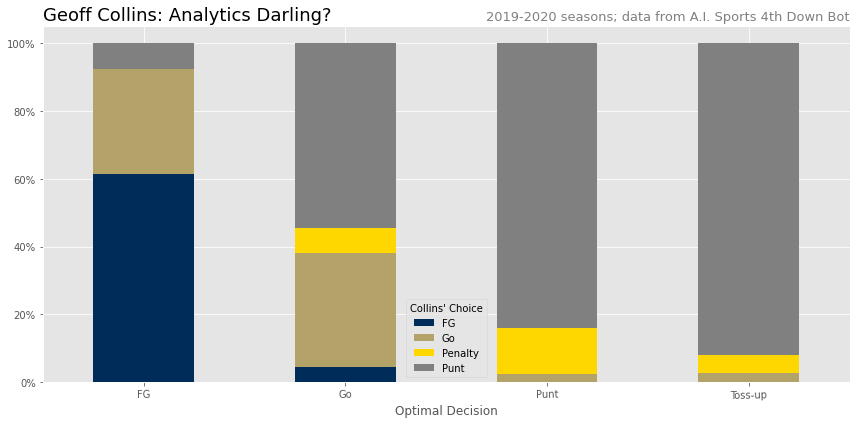

In [165]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.style.use('ggplot')

def create_decision_chart(df, title, subtitle, legend_title):
    sub_df = df.groupby("recommendation").choice.value_counts(normalize=True).unstack()
    ax = sub_df.plot(kind='bar',stacked=True,rot=1, xlabel="Optimal Decision", figsize=(12,6), color=['#002c59', '#B3A369','gold', 'gray'])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.legend(title=legend_title)
    plt.title(title, loc='left', fontsize=18)
    plt.title(subtitle, loc='right', fontsize=13, color="gray")
    plt.tight_layout()
    plt.show()

create_decision_chart(decisions[(decisions.pos_team == "Georgia Tech") & (decisions.season >= 2019)],"Geoff Collins: Analytics Darling?","2019-2020 seasons; data from A.I. Sports 4th Down Bot",'Collins\' Choice')


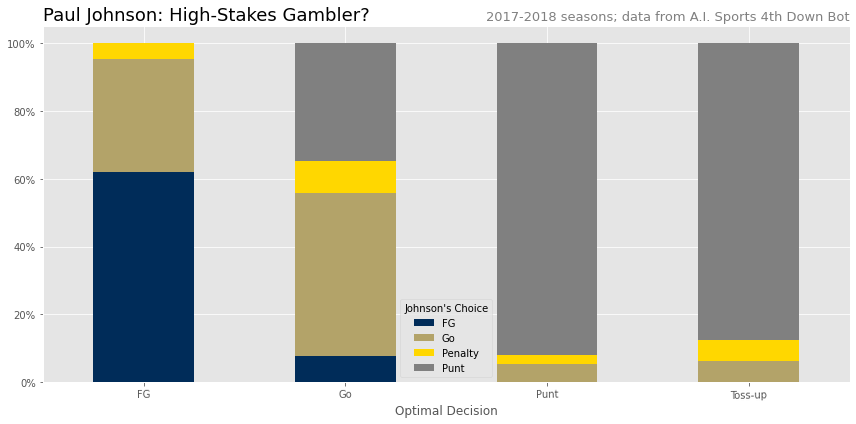

In [166]:
create_decision_chart(decisions[(decisions.pos_team == "Georgia Tech") & (decisions.season < 2019)],"Paul Johnson: High-Stakes Gambler?","2017-2018 seasons; data from A.I. Sports 4th Down Bot",'Johnson\'s Choice')

In [167]:
# base_df = overall_decisions.choice.value_counts(normalize=True).reset_index(name='count')
# base_df

In [168]:
import plotly.express as px

def make_plotly_decision_chart(df, title, subtitle, legend_title):
    base_df = df.groupby("recommendation").choice.value_counts(normalize=True).reset_index(name='count')
    fig = px.bar(base_df, x="recommendation", y="count", color="choice", title=title, color_discrete_map={
        "Go" : "#b3a369",
        "Punt" : "gray",
        "FG" : "#002c59",
        "Penalty" : "gold"
    }, labels=dict(recommendation="Optimal Decision", count="", choice=legend_title))
    fig.add_annotation(dict(xref='paper',
                            yref='paper',
                            x=1.0, y=-0.25,
                            showarrow=False,
                            align="right",
                            text ='<span style="color:#000;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>).</span><br><span style="color:#000;">Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>'
                           )
                      )
    fig.update_layout(width=1024,
                      height=512,
                    title=dict(
                        text=f'<b>{title}</b><br><i style="font-size:15px;">{subtitle}</i>',
                        font=dict(
                            family="Arial",
                            size=20,
                            color='#000000'
                        )
                    ),
                     yaxis=dict(tickformat=".0%"))
    fig.show()
    
make_plotly_decision_chart(decisions[(decisions.pos_team == "Georgia Tech") & (decisions.season >= 2019)],"Geoff Collins: Analytics Darling?","2019-2020 seasons; data from A.I. Sports 4th Down Bot",'Collins\' Choice')


In [169]:
make_plotly_decision_chart(decisions[(decisions.pos_team == "Georgia Tech") & (decisions.season < 2019)],"Paul Johnson: High-Stakes Gambler?","2017-2018 seasons; data from A.I. Sports 4th Down Bot",'Johnson\'s Choice')


In [170]:
conf_decisions = decisions.groupby(["recommendation","conference"])
tmp = conf_decisions.choice.value_counts(normalize=True).unstack().reset_index()
acc_df=pd.melt(tmp[(tmp.conference == "ACC")],id_vars=["conference","recommendation"],var_name='choice', value_name='value')

tmp_avg = decisions.groupby("recommendation").choice.value_counts(normalize=True).unstack().reset_index()
tmp_melt = pd.melt(tmp_avg,id_vars=["recommendation"],var_name='choice', value_name='value')
tmp_melt["conference"] = "FBS Average"

acc_df = acc_df.append(tmp_melt)
acc_df["percentage"] = acc_df.value.apply(lambda x: "0.0%" if (np.isnan(x) == True) else f"{round(x * 100, 1)}%")
acc_df

,conference,recommendation,choice,value,percentage
0,ACC,FG,FG,0.706339,70.6%
1,ACC,Go,FG,0.173893,17.4%
2,ACC,Punt,FG,0.004202,0.4%
3,ACC,Toss-up,FG,0.012894,1.3%
4,ACC,FG,Go,0.204398,20.4%
5,ACC,Go,Go,0.325203,32.5%
6,ACC,Punt,Go,0.025210,2.5%
7,ACC,Toss-up,Go,0.060172,6.0%
8,ACC,FG,Penalty,0.041397,4.1%
9,ACC,Go,Penalty,0.064589,6.5%


In [171]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>ACC 4th Down Decision Making (2017-2020)</b><br><span style="color:#222;font-size:12px;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
    legend_title="Coach's Choice",
    width=1024,
    height=512
)


colors = ['#002c59', '#B3A369','gold', 'gray']
recommendation_ids = ["FG","Go","Penalty","Punt"]

for r, c in zip(acc_df.choice.unique(), colors):
    plot_df = acc_df[(acc_df.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.recommendation, plot_df.conference], y=plot_df.value, text=plot_df.percentage, textposition='auto', name=r, marker_color=c),
    )    
    
fig

In [172]:
conf_szn_decisions = decisions.groupby(["season","recommendation","conference"])
tmp = conf_szn_decisions.choice.value_counts(normalize=True).unstack().reset_index()
acc_szn_df=pd.melt(tmp[tmp.conference == "ACC"],id_vars=["season","conference","recommendation"],var_name='choice', value_name='value')
nat_szn_df=pd.melt(tmp[tmp.conference != "ACC"],id_vars=["season","conference","recommendation"],var_name='choice', value_name='value')

nat_szn_df["percentage"] = nat_szn_df.value.apply(lambda x: "0.0%" if (np.isnan(x) == True) else f"{round(x * 100, 1)}%")
acc_szn_df["percentage"] = acc_szn_df.value.apply(lambda x: "0.0%" if (np.isnan(x) == True) else f"{round(x * 100, 1)}%")
acc_szn_df

,season,conference,recommendation,choice,value,percentage
0,2017,ACC,FG,FG,0.666667,66.7%
1,2017,ACC,Go,FG,0.171629,17.2%
2,2017,ACC,Punt,FG,NaN,0.0%
3,2017,ACC,Toss-up,FG,0.019108,1.9%
4,2018,ACC,FG,FG,0.687179,68.7%
...,...,...,...,...,...,...
59,2019,ACC,Toss-up,Punt,0.868132,86.8%
60,2020,ACC,FG,Punt,0.046512,4.7%
61,2020,ACC,Go,Punt,0.386076,38.6%
62,2020,ACC,Punt,Punt,0.900763,90.1%


In [200]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>National 4th Down Decision Making (2017-2020)</b><br><span style="color:#222;font-size:12px;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
    legend_title="Coach's Choice",
    width=1024,
    height=512
)


colors = ['#002c59', '#B3A369','gold', 'gray']
recommendation_ids = ["FG","Go","Penalty","Punt"]

for r, c in zip(nat_szn_df.choice.unique(), colors):
    plot_df = nat_szn_df[(acc_szn_df.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.recommendation, plot_df.season], y=plot_df.value, text=plot_df.percentage, textposition='auto', textfont=dict(size=10), name=r, marker_color=c),
    )    
    
fig

In [199]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>ACC 4th Down Decision Making (2017-2020)</b><br><span style="color:#222;font-size:12px;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
    legend_title="Coach's Choice",
    width=1024,
    height=512
)


colors = ['#002c59', '#B3A369','gold', 'gray']
recommendation_ids = ["FG","Go","Penalty","Punt"]

for r, c in zip(acc_szn_df.choice.unique(), colors):
    plot_df = acc_szn_df[(acc_szn_df.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.recommendation, plot_df.season], y=plot_df.value, text=plot_df.percentage, textposition='auto', textfont=dict(size=10), name=r, marker_color=c),
    )    
    
fig

In [175]:
conf_2020_decisions = decisions[(decisions.conference == "ACC") & (decisions.season == 2020)].groupby(["recommendation","pos_team"])
tmp = conf_2020_decisions.choice.value_counts(normalize=True).unstack().reset_index()
acc_team_df=pd.melt(tmp[tmp.pos_team.isin(acc)],id_vars=["pos_team","recommendation"],var_name='choice', value_name='value')


tmp_avg = decisions[(decisions.season == 2020)].groupby(["recommendation"]).choice.value_counts(normalize=True).unstack().reset_index()
tmp_melt = pd.melt(tmp_avg,id_vars=["recommendation"],var_name='choice', value_name='value')
tmp_melt["pos_team"] = "FBS Average"

acc_team_df = acc_team_df.append(tmp_melt)

acc_team_df["percentage"] = acc_team_df.value.apply(lambda x: "0.0%" if (np.isnan(x) == True) else f"{round(x * 100, 1)}%")
acc_team_df

,pos_team,recommendation,choice,value,percentage
0,Boston College,FG,FG,1.000000,100.0%
1,Clemson,FG,FG,0.750000,75.0%
2,Duke,FG,FG,0.545455,54.5%
3,Florida State,FG,FG,0.714286,71.4%
4,Georgia Tech,FG,FG,0.750000,75.0%
...,...,...,...,...,...
11,FBS Average,Toss-up,Penalty,0.060844,6.1%
12,FBS Average,FG,Punt,0.039660,4.0%
13,FBS Average,Go,Punt,0.390323,39.0%
14,FBS Average,Punt,Punt,0.903807,90.4%


In [176]:
acc_team_df[(acc_team_df.recommendation == "Go") & (acc_team_df.recommendation == acc_team_df.choice)].sort_values(by="value", ascending=False).head()

,pos_team,recommendation,choice,value,percentage
87,Virginia,Go,Go,0.500000,50.0%
80,Louisville,Go,Go,0.483871,48.4%
78,Florida State,Go,Go,0.475000,47.5%
79,Georgia Tech,Go,Go,0.441176,44.1%
75,Boston College,Go,Go,0.434783,43.5%


In [177]:
coastal = ["Georgia Tech","Duke","North Carolina","Miami","Pittsburgh","Virginia","Virginia Tech"]
atlantic = ["Louisville","Florida State", "Clemson", "NC State", "Wake Forest", "Boston College","Syracuse"]

coastal_df = acc_team_df[acc_team_df.pos_team.isin(coastal)]
atlantic_df = acc_team_df[acc_team_df.pos_team.isin(atlantic)]

In [178]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>ACC Atlantic 4th Down Decision Making in 2020</b><br><span style="color:#222;font-size:12px;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
    legend_title="Coach's Choice",
    width=1024,
    height=512
)


colors = ['#002c59', '#B3A369','gold', 'gray']
recommendation_ids = ["FG","Go","Penalty","Punt"]


for r, c in zip(atlantic_df.choice.unique(), colors):
    plot_df = atlantic_df[(atlantic_df.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.recommendation, plot_df.pos_team], y=plot_df.value, name=r, marker_color=c),
    )    
    
fig

In [179]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>ACC Coastal 4th Down Decision Making in 2020</b><br><span style="color:#222;font-size:12px;">Recommendations provided by A.I. Sports 4th Down Bot, created by Jared Lee (<a href="https://twitter.com/JDLee">@JDLee</a>). Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
    legend_title="Coach's Choice",
    width=1024,
    height=512
)


colors = ['#002c59', '#B3A369','gold', 'gray']
recommendation_ids = ["FG","Go","Penalty","Punt"]


for r, c in zip(coastal_df.choice.unique(), colors):
    plot_df = coastal_df[(coastal_df.choice == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.recommendation, plot_df.pos_team], y=plot_df.value, name=r, marker_color=c),
    )    
    
fig

In [180]:
pbp_data = pd.DataFrame()
years = range(2020, 2021)
for i in years:
    url = f"https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_{i}.parquet"
    print(f"Pulling url {url}")
    i_data = pd.read_parquet(url, engine='pyarrow')

    #sort=True eliminates a warning and alphabetically sorts columns
    pbp_data = pbp_data.append(i_data, sort=True)

#Give each row a unique index
pbp_data.reset_index(drop=True, inplace=True)
pbp_data.head()

Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2020.parquet


,EPA,ExpScoreDiff,ExpScoreDiff_Time_Ratio,FG_after,FG_before,Goal_To_Go,Goal_To_Go_end,No_Score_after,No_Score_before,Opp_FG_after,...,yds_kickoff,yds_kickoff_return,yds_penalty,yds_punt_gained,yds_punt_return,yds_punted,yds_receiving,yds_rushed,yds_sacked,year
0,0.000000,0.833168,0.000231,0.146772,0.170347,False,False,0.002032,0.001775,0.110364,...,65.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0
1,-0.942772,0.833168,0.000231,0.134086,0.146772,False,False,0.002164,0.002032,0.129309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0
2,-0.580199,-0.109604,-0.000030,0.113570,0.134086,False,False,0.002116,0.002164,0.142802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2020.0
3,3.684710,-0.689802,-0.000192,0.205539,0.113570,False,False,0.001360,0.002116,0.060326,...,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,2020.0
4,-0.336147,2.994907,0.000832,0.218856,0.205539,False,False,0.001399,0.001360,0.064455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2020.0


In [181]:
pbp_data["is_GT"] = np.where(pbp_data.pos_team.str.contains("Georgia Tech"), "Georgia Tech", "FBS Average")
valid_plays = pbp_data[(pbp_data.down > 0) & (pbp_data.down < 5) & (pbp_data.distance > 0) & (pbp_data.distance < 16) & (pbp_data.kick_play == False) & (pbp_data.punt_play == False)]

In [182]:
yardage_epa_base = valid_plays.groupby(["is_GT", 'distance']).EPA.mean()
yardage_epa = yardage_epa_base.reset_index(name='avgEPA')
yardage_epa

,is_GT,distance,avgEPA
0,FBS Average,1.0,-0.136450
1,FBS Average,2.0,-0.173797
2,FBS Average,3.0,-0.096108
3,FBS Average,4.0,-0.050286
4,FBS Average,5.0,-0.040567
5,FBS Average,6.0,-0.092425
6,FBS Average,7.0,-0.090527
7,FBS Average,8.0,-0.032025
8,FBS Average,9.0,-0.068948
9,FBS Average,10.0,-0.084191


In [183]:
def generate_epa_fig(df, title, subtitle, color="is_GT", color_map={ "Georgia Tech" : "#b3a369", "FBS Average" : "blue" }):
    fig = px.scatter(df,
                     x="distance", 
                     y="avgEPA", 
                     color=color, 
                     labels={"distance":"Yards to Go", "avgEPA":"EPA/Play", f"{color}":""}, 
                     trendline="lowess", 
                     color_discrete_map=color_map
                    )
    fig.update_layout(width=1024,
                          height=512,
                          xaxis = dict(
                            tickmode = 'linear',
#                             range=[0, 16],
                            tick0 = 0,
                            dtick = 1
                          ),
                          yaxis = dict(
                            range=[-1, 1],
                            tickmode = 'linear',
                            tick0 = -1,
                            dtick = 0.5
                          ),
                          title=dict(
                            yanchor="top",
                            text=f'<b>{title}</b> <i style="font-size:15px;">{subtitle}</i>',
                            font=dict(
                                family="Arial",
                                size=20,
                                color='#000000'
                            ),
                            pad = dict(b = 90)
                          )
                         )
    fig.add_annotation(dict(xref='paper',
                        yref='paper',
                        x=1.0, y=-0.2,
                        showarrow=False,
                        align="right",
                        text ='<span style="color:#000;">Data provided by <a href="https://twitter.com/cfbscrapR">@cfbscrapR</a>.</span> <span style="color:#000;">Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>'
                       )
                  )
    return fig

In [184]:
epa_fig = generate_epa_fig(yardage_epa, "Dave Patenaude vs FBS Average", "EPA/Play by Distance | All Situations")
epa_fig.show()

In [185]:
pass_epa_base = valid_plays[valid_plays["pass"] == True].groupby(["distance", 'is_GT']).EPA.mean()
pass_epa = pass_epa_base.reset_index(name='avgEPA')
pass_epa

pass_epa_fig = generate_epa_fig(pass_epa, "Dave Patenaude vs FBS Average", "EPA/Play by Distance | Passes")
pass_epa_fig.show()

In [186]:
rush_epa_base = valid_plays[valid_plays["rush"] == True].groupby(["distance", 'is_GT']).EPA.mean()
rush_epa = rush_epa_base.reset_index(name='avgEPA')
rush_epa

rush_epa_fig = generate_epa_fig(rush_epa, "Dave Patenaude vs FBS Average", "EPA/Play by Distance | Rushes")
rush_epa_fig.show()

In [187]:
early_downs_pass_epa_base = valid_plays[(valid_plays["pass"] == True) & (valid_plays.down < 3)].groupby(["distance", 'is_GT']).EPA.mean()
early_downs_pass = early_downs_pass_epa_base.reset_index(name='avgEPA')
early_downs_pass

ed_pass_fig = generate_epa_fig(early_downs_pass, "Dave Patenaude vs FBS Average", "EPA/Play by Distance | Early Downs Passing")
ed_pass_fig.show()

In [188]:
early_downs_rush_epa_base = valid_plays[(valid_plays["rush"] == True) & (valid_plays.down < 3)].groupby(["distance", 'is_GT']).EPA.mean()
early_downs_rush = early_downs_rush_epa_base.reset_index(name='avgEPA')
early_downs_pass

ed_rush_fig = generate_epa_fig(early_downs_rush, "Dave Patenaude vs FBS Average", "EPA/Play by Distance | Early Downs Rushing")
ed_rush_fig.show()

In [189]:
pbp_data = pd.DataFrame()
years = range(2014, 2021)
for i in years:
    url = f"https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_{i}.parquet"
    print(f"Pulling url {url}")
    i_data = pd.read_parquet(url, engine='pyarrow')

    #sort=True eliminates a warning and alphabetically sorts columns
    pbp_data = pbp_data.append(i_data, sort=True)

#Give each row a unique index
pbp_data.reset_index(drop=True, inplace=True)
pbp_data.head()

Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2014.parquet
Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2015.parquet
Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2016.parquet
Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2017.parquet
Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2018.parquet
Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2019.parquet
Pulling url https://raw.githubusercontent.com/saiemgilani/cfbscrapR-data/master/data/parquet/pbp_players_pos_2020.parquet


,EPA,ExpScoreDiff,ExpScoreDiff_Time_Ratio,FG_after,FG_before,Goal_To_Go,Goal_To_Go_end,No_Score_after,No_Score_before,Opp_FG_after,...,yds_kickoff,yds_kickoff_return,yds_penalty,yds_punt_gained,yds_punt_return,yds_punted,yds_receiving,yds_rushed,yds_sacked,year
0,-0.565384,0.835848,0.000232,0.132497,0.170311,False,False,0.002218,0.001810,0.123708,...,64.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
1,-0.469578,0.270464,0.000075,0.120739,0.132497,False,False,0.002423,0.002218,0.134912,...,NaN,NaN,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,2014.0
2,-0.484325,-0.488417,-0.000136,0.111865,0.139679,False,False,0.002728,0.002383,0.149630,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2014.0
3,-0.214516,-0.972742,-0.000273,0.093482,0.111865,False,False,0.002888,0.002728,0.155241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2014.0
4,2.529815,-1.187259,-0.000336,0.158063,0.093482,False,False,0.002756,0.002888,0.097974,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,2014.0


In [190]:
pbp_data["coach"] = np.where(pbp_data.pos_team.str.contains("Georgia Tech"), np.where(pbp_data.year <= 2018, "Paul Johnson", "Geoff Collins"), "FBS Average")
coach_valid_plays = pbp_data[(pbp_data.down > 0) & (pbp_data.down < 5) & (pbp_data.distance > 0) & (pbp_data.distance < 16) & (pbp_data.kick_play == False) & (pbp_data.punt_play == False)]

In [191]:
coach_yardage_epa_base = coach_valid_plays.groupby(["coach", 'distance']).EPA.mean()
coach_yardage_epa = coach_yardage_epa_base.reset_index(name='avgEPA')
coach_yardage_epa

,coach,distance,avgEPA
0,FBS Average,1.0,-0.212302
1,FBS Average,2.0,-0.159192
2,FBS Average,3.0,-0.122488
3,FBS Average,4.0,-0.077841
4,FBS Average,5.0,-0.076781
5,FBS Average,6.0,-0.079506
6,FBS Average,7.0,-0.094632
7,FBS Average,8.0,-0.091954
8,FBS Average,9.0,-0.108614
9,FBS Average,10.0,-0.098246


In [192]:
coach_fig = generate_epa_fig(coach_yardage_epa, "Paul Johnson vs Geoff Collins", "EPA/Play by Distance | All Situations", color="coach", color_map={ "Paul Johnson" : "#b3a369", "Geoff Collins" : "blue", "FBS Average" : "gray" })
coach_fig.show()

In [198]:
gt_stuff = obvious_go[(obvious_go.pos_team == "Georgia Tech")].play_id.astype(int).to_list()
print(len(gt_stuff))
# gt_stuff
obvious_go[(obvious_go.pos_team == "Georgia Tech")]
print(gt_stuff)

100
[400933840101888000, 400937473102949248, 400937473104859392, 400937483102989120, 400937483104858816, 400937501101934848, 400937505101998080, 400937505102935360, 400937505102994048, 400937505104888896, 400937512104994560, 400937517102966400, 400937517104874112, 400937522103884672, 400937522103958016, 400937522104904320, 400937522104916480, 401013090101934848, 401013100102974464, 401013100104858368, 401013100104995584, 401013100105000000, 401013112102858496, 401013112102898624, 401013134102000000, 401013145101867392, 401013145101916672, 401013145102849920, 401013145102959424, 401013145104849920, 401013145104988096, 401013153101965760, 401013165104849920, 401013172101907328, 401013177103864832, 401012352101927168, 401012352102906880, 401012352102985984, 401012352102995136, 401111653102914304, 401111653102996736, 401112441102934464, 401112441104854528, 401112452101945472, 401112452102936000, 401112452103859520, 401112452103956864, 401112469102849920, 401112469103896640, 401112469104849

In [194]:
obvious_go_success = [{"year":2017,"epa_success":1,"count":7,"total":17,"prop":0.4118},{"year":2018,"epa_success":1,"count":5,"total":13,"prop":0.3846},{"year":2019,"epa_success":1,"count":13,"total":29,"prop":0.4483},{"year":2020,"epa_success":1,"count":14,"total":23,"prop":0.6087}] 
coach_go_success = pd.DataFrame(obvious_go_success)
coach_go_success["coach"] = np.where(coach_go_success.year <= 2018, "Paul Johnson", "Geoff Collins")
coach_go_success["color"] = np.where(coach_go_success.coach == "Paul Johnson", "#b3a369", "#002c59")
coach_go_success

,year,epa_success,count,total,prop,coach,color
0,2017,1,7,17,0.4118,Paul Johnson,#b3a369
1,2018,1,5,13,0.3846,Paul Johnson,#b3a369
2,2019,1,13,29,0.4483,Geoff Collins,#002c59
3,2020,1,14,23,0.6087,Geoff Collins,#002c59


In [195]:
fig = go.Figure()

fig.update_layout(
    template="simple_white",
#     xaxis=dict(title_text="Optimal Decision"),
    yaxis=dict(tickformat=".0%"),
    barmode="stack",
    title='<b>Which ACC teams <span style="color:#b3a369;">go for it</span> when they <span style="color:#b3a369;">should?</span> (2020)</b><br><span style="color:#222;font-size:12px;">When the A.I. Sports 4th Down Bot (created by Jared Lee, <a href="https://twitter.com/JDLee">@JDLee</a>) recommends going for it (at least +1.5 WP).</span><br><span style="color:#222;font-size:12px;margin-top:0;">Chart created by Akshay Easwaran (<a href="https://twitter.com/akeaswaran">@akeaswaran</a>).</span>',
#     legend_title="Coach's Choice",
    width=1024,
    height=512
)

for r in coach_go_success.coach.unique():
    plot_df = coach_go_success[(coach_go_success.coach == r)]
    fig.add_trace(
        go.Bar(x=[plot_df.coach, plot_df.year], y=plot_df.prop, text=plot_df["total"], textposition='auto', marker_color=plot_df.color),
    )    
    
fig